<img align="center" style="max-width: 900px; height: auto" src="../assets/banner.png">

###  EuroSAT Classification - Pretrained Model Implementation

<img align="right" style="max-width: 200px; height: auto" src="../assets/hsg_logo.png">

7,854,1.00 MCS Machine Learning, University of St.Gallen (HSG)

**Task**: Predict EuroSAT class for each test image using a pretrained ResNet model with proper band alignment.

**Key Features**:
- Proper band reordering (TRAIN_ORDER → TEST_ORDER)
- Pretrained ResNet18 backbone with custom first layer for 11-band input
- Transfer learning with fine-tuning
- Domain adaptation via statistical normalization
- 11-band input (B10 and B9 dropped, B8A repositioned)

**Configuration**:
- **Freeze Backbone**: Set `CONFIG['freeze_backbone']` to `True` for faster training and lower memory usage (trains only classifier head), or `False` for full fine-tuning
- **Model Variants**: Options include `'resnet18'`, `'resnet34'`, or `'resnet50'`
- **Hyperparameters**: Learning rate, batch size, epochs, and weight decay can be adjusted in CONFIG section
- **Data paths**: Script automatically detects EuroSAT_MS and testset directories from current working directory

**Expected Output Files**:
- `best_model_pretrained.pth` - Best model checkpoint (contains model state, optimizer state, training history, and statistics)
- `predictions_pretrained.csv` - Test set predictions in submission format
- `training_history_pretrained.png` - Training/validation loss and accuracy curves
- `confusion_matrix_pretrained.png` - Confusion matrix on validation set


### ⚠️ Important Change: 11-Band Configuration

**Modified from 12 to 11 bands by removing B9 (Band 9)**

- Original test data: 12 bands `[B1-B8, B8A, B9, B11, B12]`
- **New configuration: 11 bands `[B1-B8, B8A, B11, B12]` (B9 removed)**
- Training data: Still loaded as 13 bands, but B9 and B10 are dropped during reordering
- Model input: 11 channels instead of 12

## 1. Import Libraries

In [ ]:
# Basic libraries
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path

# Raster data handling
import rasterio as rio
from rasterio.plot import reshape_as_image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Utilities
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
# NOTE: Full reproducibility may require setting PYTHONHASHSEED
# Run the notebook with: PYTHONHASHSEED=0 python -m jupyter notebook
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(RANDOM_SEED)

print(f"✓ Random seeds set to {RANDOM_SEED} for reproducibility")


## 2. Configuration

In [ ]:
def get_device():
    """Select the best available device for training."""
    if torch.backends.mps.is_available():
        try:
            test_tensor = torch.zeros(1).to('mps')
            device = torch.device('mps')
            print("✓ Metal Performance Shaders (MPS) available and working")
            return device
        except Exception as e:
            print(f"⚠ MPS available but encountered issue: {e}")
            print("  Falling back to CPU")
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("✓ CUDA GPU available")
        return device
    
    device = torch.device('cpu')
    print("ℹ Using CPU for training")
    return device

def find_eurosat_dir():
    """Automatically find EuroSAT directory."""
    candidates = [
        'EuroSAT_MS',
        '../EuroSAT_MS',
        '/Users/gian1/CODE/HSG/HS25/ML/ML2025-Lab/EuroSAT_MS',
    ]
    
    for path in candidates:
        if os.path.isdir(path):
            return os.path.abspath(path)
    
    raise FileNotFoundError("EuroSAT_MS directory not found in expected locations")

def find_testset_dir():
    """Automatically find test dataset directory."""
    candidates = [
        os.path.join(os.getcwd(), 'testset', 'testset'),
        os.path.join(os.getcwd(), 'testset'),
        os.path.join(os.getcwd(), '..', 'testset', 'testset'),
        os.path.join(os.getcwd(), '..', 'testset'),
    ]
    
    for path in candidates:
        if os.path.isdir(path):
            return os.path.abspath(path)
    
    raise FileNotFoundError("testset directory not found in expected locations")

CONFIG = {
    'eurosat_dir': find_eurosat_dir(),
    'batch_size': 32,
    'num_epochs': 20,
    'learning_rate': 1e-5,
    'weight_decay': 1e-4,
    'validation_split': 0.2,
    'num_workers': 0,
    'device': get_device(),
    'freeze_backbone': True,  # Set to True to only train the classifier head
    'pretrained_model': 'resnet18'  # Options: resnet18, resnet34, resnet50
}

# EuroSAT classes
CLASSES = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: cls for idx, cls in enumerate(CLASSES)}

print(f"Number of classes: {NUM_CLASSES}")
print(f"Using device: {CONFIG['device']}")
print(f"EuroSAT directory: {CONFIG['eurosat_dir']}")
print(f"Pretrained model: {CONFIG['pretrained_model']}")
print(f"Freeze backbone: {CONFIG['freeze_backbone']}")


✓ Metal Performance Shaders (MPS) available and working
Number of classes: 10
Using device: mps
Pretrained model: resnet18
Freeze backbone: True


## 3. Band Reordering Functions

**CRITICAL**: Training data has 13 bands in order `[B1-B9, B10, B11, B12, B8A]`  
Test data has 12 bands in order `[B1-B8, B8A, B9, B11, B12]` (no B10)

**We remove B9 and B10, keeping only 11 bands: `[B1-B8, B8A, B11, B12]`**

In [284]:
# Band order definitions
TRAIN_ORDER = ["B1","B2","B3","B4","B5","B6","B7","B8","B9","B10","B11","B12","B8A"]
TEST_ORDER = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12"]  # Removed B9 and B10

def reorder_bands(img, src_order, dst_order):
    """
    Reorder spectral bands from source order to destination order.
    
    Args:
        img: numpy array of shape (H, W, C) where C is number of bands
        src_order: list of band names in source order
        dst_order: list of band names in destination order
    
    Returns:
        Reordered image with shape (H, W, len(dst_order))
    """
    idx = [src_order.index(b) for b in dst_order if b in src_order]
    return img[:, :, idx]

print(f"TRAIN_ORDER ({len(TRAIN_ORDER)} bands): {TRAIN_ORDER}")
print(f"TEST_ORDER ({len(TEST_ORDER)} bands): {TEST_ORDER}")
print(f"\nB8A position: Training idx={TRAIN_ORDER.index('B8A')}, Test idx={TEST_ORDER.index('B8A')}")

TRAIN_ORDER (13 bands): ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B8A']
TEST_ORDER (11 bands): ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

B8A position: Training idx=12, Test idx=8


In [ ]:
# Verify the band removal works correctly
print("\n" + "="*60)
print("BAND CONFIGURATION VERIFICATION")
print("="*60)

try:
    # Test with a sample training image
    if len(train_samples) > 0:
        with rio.open(train_samples[0], "r") as f:
            train_img = f.read()
            train_img = reshape_as_image(train_img)
            print(f"\n✓ Training image original shape: {train_img.shape}")
            train_img_reordered = reorder_bands(train_img, TRAIN_ORDER, TEST_ORDER)
            print(f"✓ Training image after reordering: {train_img_reordered.shape}")
            assert train_img_reordered.shape[2] == 11, f"Expected 11 bands, got {train_img_reordered.shape[2]}"
            print("✓ Training data: 11 bands confirmed!")

    # Test with a sample test image
    if len(test_samples) > 0:
        test_img = np.load(test_samples[0])
        print(f"\n✓ Test image original shape: {test_img.shape}")
        if test_img.shape[2] == 12:
            test_img_fixed = np.delete(test_img, 9, axis=2)  # Remove B9 at index 9
            print(f"✓ Test image after removing B9: {test_img_fixed.shape}")
            assert test_img_fixed.shape[2] == 11, f"Expected 11 bands, got {test_img_fixed.shape[2]}"
            print("✓ Test data: 11 bands confirmed!")
        else:
            print(f"⚠️  Test image has {test_img.shape[2]} bands (expected 12)")

    print(f"\n✅ Both training and test data will have 11 bands")
    print("="*60)
except Exception as e:
    print(f"⚠️  Band verification failed: {e}")
    print("Please ensure EuroSAT_MS and testset directories are accessible")
    print("="*60)



BAND CONFIGURATION VERIFICATION

✓ Training image original shape: (64, 64, 13)
✓ Training image after reordering: (64, 64, 11)
✓ Training data: 11 bands confirmed!

✓ Test image original shape: (64, 64, 12)
✓ Test image after removing B9: (64, 64, 11)
✓ Test data: 11 bands confirmed!

✅ Both training and test data will have 11 bands


## 4. Dataset Class (Same as Clean Implementation)

In [ ]:
class ImprovedEuroSATDataset(Dataset):
    """
    Improved dataset that:
    1. Correctly reorders bands from TRAIN_ORDER to TEST_ORDER
    2. Applies per-band normalization using training statistics
    3. Handles both training and test data consistently
    4. Includes robust error handling and validation
    """
    def __init__(self, samples, labels=None, transform=None, 
                 normalize=True, train_stats=None):
        self.samples = samples
        self.labels = labels
        self.transform = transform
        self.normalize = normalize
        self.train_stats = train_stats
        
        if not isinstance(samples, list):
            raise ValueError("samples must be a list")
        if len(samples) == 0:
            raise ValueError("samples list cannot be empty")
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        try:
            # Load image
            if isinstance(self.samples[idx], str):
                file_path = self.samples[idx]
                
                if not os.path.exists(file_path):
                    raise FileNotFoundError(f"File not found: {file_path}")
                
                if file_path.endswith('.npy'):
                    # Test data: originally 12 bands [B1-B8, B8A, B9, B11, B12]
                    # We need to remove B9 to get 11 bands
                    img = np.load(file_path)
                    if img.dtype == np.uint16:
                        img = img.astype(np.float32)
                    
                    # Original test order: ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"]
                    # B9 is at index 9, so we remove it
                    if img.shape[2] == 12:
                        # Remove B9 (index 9)
                        img = np.delete(img, 9, axis=2)  # Now 11 bands: [B1-B8, B8A, B11, B12]
                    elif img.shape[2] != 11:
                        raise ValueError(f"Expected 12 or 11 bands in test data, got {img.shape[2]}")
                else:
                    # Training data: load and reorder
                    if not file_path.endswith('.tif'):
                        raise ValueError(f"Unsupported file format: {file_path}")
                    
                    with rio.open(file_path, "r") as f:
                        img = f.read()  # Read all bands
                        if img.dtype == np.uint16:
                            img = img.astype(np.float32)
                        img = reshape_as_image(img)
                        
                        # Verify we have the expected number of bands
                        if img.shape[2] != 13:
                            raise ValueError(f"Expected 13 bands in training data, got {img.shape[2]}")
                        
                        # Reorder from TRAIN_ORDER to TEST_ORDER (drops B10 and B9)
                        img = reorder_bands(img, TRAIN_ORDER, TEST_ORDER)
            else:
                img = self.samples[idx]
                if img.dtype == np.uint16:
                    img = img.astype(np.float32)
                    
                # If loaded from memory and has 13 bands, reorder
                if img.shape[2] == 13:
                    img = reorder_bands(img, TRAIN_ORDER, TEST_ORDER)
                # If loaded from memory and has 12 bands (test format), remove B9
                elif img.shape[2] == 12:
                    img = np.delete(img, 9, axis=2)
                elif img.shape[2] != 11:
                    raise ValueError(f"Expected 11, 12, or 13 bands, got {img.shape[2]}")
            
            # Verify final shape
            if img.shape[2] != 11:
                raise ValueError(f"After processing, expected 11 bands but got {img.shape[2]}")
            
            # Apply per-band normalization using training statistics
            if self.normalize and self.train_stats is not None:
                img_normalized = np.zeros_like(img, dtype=np.float32)
                num_bands = img.shape[2]
                
                for band_idx in range(num_bands):
                    band_data = img[:, :, band_idx].astype(np.float32)
                    
                    if band_idx < len(self.train_stats['means']):
                        mean = self.train_stats['means'][band_idx]
                        std = self.train_stats['stds'][band_idx]
                        # Z-score normalization with clipping
                        img_normalized[:, :, band_idx] = (band_data - mean) / (std + 1e-8)
                        img_normalized[:, :, band_idx] = np.clip(img_normalized[:, :, band_idx], -10, 10)
                    else:
                        # Fallback: simple normalization
                        img_normalized[:, :, band_idx] = band_data / 10000.0
                
                img = img_normalized
            else:
                # Simple normalization if no stats provided
                img = img.astype(np.float32) / 10000.0
            
            # Convert to tensor (C, H, W)
            img = torch.from_numpy(img.transpose(2, 0, 1))
            
            # Verify tensor shape
            if img.shape[0] != 11:
                raise ValueError(f"Tensor has {img.shape[0]} channels, expected 11")
            
            # Apply transforms if any
            if self.transform:
                img = self.transform(img)
            
            if self.labels is not None:
                return img, self.labels[idx]
            return img, self.samples[idx]  # Return filename for test data
            
        except Exception as e:
            raise RuntimeError(f"Error loading sample {idx} ({self.samples[idx]}): {e}")

print("✓ ImprovedEuroSATDataset class defined with robust error handling")


✓ ImprovedEuroSATDataset class defined


## 5. Pretrained Model Architecture

In [ ]:
class PretrainedEuroSATClassifier(nn.Module):
    """
    Pretrained model (ResNet) adapted for 11-band satellite imagery.
    
    Architecture:
    1. Load pretrained ResNet on ImageNet (3-channel RGB)
    2. Replace first conv layer to accept 11 channels
    3. Initialize new conv weights intelligently
    4. Replace final FC layer for 10 classes
    5. Optionally freeze backbone for transfer learning
    
    Args:
        num_classes (int): Number of output classes (default: 10)
        input_channels (int): Number of input channels (default: 11)
        model_name (str): ResNet variant ('resnet18', 'resnet34', 'resnet50')
        pretrained (bool): Whether to use ImageNet pretrained weights
        freeze_backbone (bool): Whether to freeze backbone during training
    """
    def __init__(self, num_classes=10, input_channels=11, 
                 model_name='resnet18', pretrained=True, freeze_backbone=False):
        super(PretrainedEuroSATClassifier, self).__init__()
        
        if model_name not in ['resnet18', 'resnet34', 'resnet50']:
            raise ValueError(f"Unsupported model: {model_name}")
        
        # Load pretrained model
        if model_name == 'resnet18':
            self.backbone = models.resnet18(pretrained=pretrained)
        elif model_name == 'resnet34':
            self.backbone = models.resnet34(pretrained=pretrained)
        else:  # resnet50
            self.backbone = models.resnet50(pretrained=pretrained)
        
        # Replace first conv layer for 11-band input
        original_conv1 = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(
            input_channels, 64, 
            kernel_size=7, stride=2, padding=3, bias=False
        )
        
        # Initialize new conv layer weights
        if pretrained:
            with torch.no_grad():
                # Original weights: (64, 3, 7, 7)
                # New weights: (64, 11, 7, 7)
                original_weights = original_conv1.weight.data
                # Repeat the 3-channel weights to cover 11 channels
                repeats = (input_channels // 3) + 1
                new_weights = original_weights.repeat(1, repeats, 1, 1)
                # Trim to exactly 11 channels
                new_weights = new_weights[:, :input_channels, :, :]
                # Scale down to maintain similar activation magnitudes
                new_weights = new_weights / (input_channels / 3)
                self.backbone.conv1.weight.data = new_weights
        
        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            # Unfreeze the new conv1 layer
            for param in self.backbone.conv1.parameters():
                param.requires_grad = True
        
        # Get the number of features from the backbone
        if model_name in ['resnet18', 'resnet34']:
            num_features = 512
        else:  # resnet50
            num_features = 2048
        
        # Replace final FC layer with custom classifier head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        """Forward pass through the network."""
        return self.backbone(x)

print("✓ PretrainedEuroSATClassifier class defined")


✓ PretrainedEuroSATClassifier class defined


## 6. Load and Prepare Data

In [ ]:
# Load training data
train_samples = []
train_labels = []

print("Loading training data...")
for idx, class_name in enumerate(CLASSES):
    class_folder = os.path.join(CONFIG['eurosat_dir'], class_name)
    if not os.path.isdir(class_folder):
        raise FileNotFoundError(f"Class folder not found: {class_folder}")
    
    tif_files = glob.glob(os.path.join(class_folder, '*.tif'))
    if len(tif_files) == 0:
        raise FileNotFoundError(f"No .tif files found in {class_folder}")
    
    train_samples.extend(tif_files)
    train_labels.extend([idx] * len(tif_files))
    print(f"  {class_name}: {len(tif_files)} samples")

print(f"\nTotal training samples: {len(train_samples)}")
if len(train_samples) == 0:
    raise ValueError("No training samples loaded!")

# Load test data
testset_dir = find_testset_dir()
test_samples = sorted(glob.glob(os.path.join(testset_dir, '*.npy')))
print(f"Loaded {len(test_samples)} test samples from {testset_dir}")

if len(test_samples) == 0:
    raise ValueError("No test samples loaded!")


Loading training data...
  AnnualCrop: 3000 samples
  Forest: 3000 samples
  HerbaceousVegetation: 3000 samples
  Highway: 2500 samples
  Industrial: 2500 samples
  Pasture: 2000 samples
  PermanentCrop: 2500 samples
  Residential: 3000 samples
  River: 2500 samples
  SeaLake: 3000 samples

Total training samples: 27000

Loaded 4232 test samples from /Users/gian1/CODE/HSG/HS25/ML/ML2025-Lab/testset/testset


## 7. Compute Training Statistics (11 bands)

In [ ]:
print("Computing training statistics for 11 bands (B9 removed)...")
sample_size = min(200, len(train_samples))
print(f"Sampling {sample_size} images for statistics calculation...")

# Sample subset for statistics
sample_indices = np.random.choice(len(train_samples), sample_size, replace=False)
sampled_data = []

try:
    for idx in tqdm(sample_indices, desc="Loading samples"):
        try:
            with rio.open(train_samples[idx], "r") as f:
                img = f.read()
                img = reshape_as_image(img)
                # Reorder to TEST_ORDER (11 bands - B9 and B10 removed)
                img = reorder_bands(img, TRAIN_ORDER, TEST_ORDER)
                sampled_data.append(img)
        except Exception as e:
            print(f"Warning: Failed to load {train_samples[idx]}: {e}")
            continue
    
    if len(sampled_data) == 0:
        raise ValueError("No training samples could be loaded for statistics")
    
    # Compute per-band statistics
    sampled_data = np.array(sampled_data)  # (N, H, W, 11)
    train_stats_11band = {
        'means': np.mean(sampled_data, axis=(0, 1, 2)).tolist(),
        'stds': np.std(sampled_data, axis=(0, 1, 2)).tolist(),
        'mins': np.min(sampled_data, axis=(0, 1, 2)).tolist(),
        'maxs': np.max(sampled_data, axis=(0, 1, 2)).tolist()
    }
    
    print(f"\n✓ Computed statistics for {len(train_stats_11band['means'])} bands")
    print(f"  Mean range: [{min(train_stats_11band['means']):.1f}, {max(train_stats_11band['means']):.1f}]")
    print(f"  Std range: [{min(train_stats_11band['stds']):.1f}, {max(train_stats_11band['stds']):.1f}]")
    
except Exception as e:
    print(f"Error computing training statistics: {e}")
    raise


Computing training statistics for 11 bands (B9 removed)...
Sampling 200 images for statistics calculation...


Loading samples:   0%|          | 0/200 [00:00<?, ?it/s]


✓ Computed statistics for 11 bands
  Mean range: [922.0, 2564.8]
  Std range: [244.8, 1197.8]


## 8. Create Data Augmentation

In [290]:
# Training augmentations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
])

# Validation/test transforms (no augmentation)
val_transforms = None

print("✓ Data augmentation configured")

✓ Data augmentation configured


## 9. Create Datasets and DataLoaders

In [291]:
# Split training data
train_paths, val_paths, train_labels_split, val_labels_split = train_test_split(
    train_samples, train_labels,
    test_size=CONFIG['validation_split'],
    stratify=train_labels,
    random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

# Create datasets (using 11-band statistics)
train_dataset = ImprovedEuroSATDataset(
    train_paths, train_labels_split,
    transform=train_transforms,
    normalize=True,
    train_stats=train_stats_11band
)

val_dataset = ImprovedEuroSATDataset(
    val_paths, val_labels_split,
    transform=val_transforms,
    normalize=True,
    train_stats=train_stats_11band
)

test_dataset = ImprovedEuroSATDataset(
    test_samples, labels=None,
    transform=val_transforms,
    normalize=True,
    train_stats=train_stats_11band
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

print("\n✓ Datasets and DataLoaders created")

# Verify band alignment
train_sample, _ = train_dataset[0]
test_sample, _ = test_dataset[0]
print(f"\nBand alignment check:")
print(f"  Train shape: {train_sample.shape}")
print(f"  Test shape: {test_sample.shape}")
print(f"  ✓ Match!" if train_sample.shape == test_sample.shape else "  ✗ Mismatch!")

Training samples: 21600
Validation samples: 5400

✓ Datasets and DataLoaders created

Band alignment check:
  Train shape: torch.Size([11, 64, 64])
  Test shape: torch.Size([11, 64, 64])
  ✓ Match!


## 10. Initialize Model, Loss, and Optimizer

In [292]:
# Create pretrained model (11 channels - B9 removed)
model = PretrainedEuroSATClassifier(
    num_classes=NUM_CLASSES,
    input_channels=11,
    model_name=CONFIG['pretrained_model'],
    pretrained=True,
    freeze_backbone=CONFIG['freeze_backbone']
).to(CONFIG['device'])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: PretrainedEuroSATClassifier ({CONFIG['pretrained_model']})")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
# Use different learning rates for backbone and classifier
if CONFIG['freeze_backbone']:
    # Only train the classifier head
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
else:
    # Train entire model with discriminative learning rates
    optimizer = optim.AdamW([
        {'params': model.backbone.conv1.parameters(), 'lr': CONFIG['learning_rate']},
        {'params': model.backbone.layer1.parameters(), 'lr': CONFIG['learning_rate'] * 0.1},
        {'params': model.backbone.layer2.parameters(), 'lr': CONFIG['learning_rate'] * 0.1},
        {'params': model.backbone.layer3.parameters(), 'lr': CONFIG['learning_rate'] * 0.1},
        {'params': model.backbone.layer4.parameters(), 'lr': CONFIG['learning_rate'] * 0.1},
        {'params': model.backbone.fc.parameters(), 'lr': CONFIG['learning_rate']}
    ], weight_decay=CONFIG['weight_decay'])

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

print("\n✓ Model, loss, optimizer, and scheduler configured")

Model: PretrainedEuroSATClassifier (resnet18)
Total parameters: 11,336,010
Trainable parameters: 168,906
Frozen parameters: 11,167,104

✓ Model, loss, optimizer, and scheduler configured


## 11. Training Functions

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on
    
    Returns:
        tuple: (average_loss, accuracy_percentage)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        if device.type == 'mps':
            torch.mps.synchronize()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        pbar.set_postfix({
            'Loss': f'{running_loss/(pbar.n+1):.4f}',
            'Acc': f'{100*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch.
    
    Args:
        model: PyTorch model to validate
        val_loader: DataLoader for validation data
        criterion: Loss function
        device: Device to validate on
    
    Returns:
        tuple: (average_loss, accuracy_percentage)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            if device.type == 'mps':
                torch.mps.synchronize()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{running_loss/(pbar.n+1):.4f}',
                'Acc': f'{100*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("✓ Training functions defined")


✓ Training functions defined


## 12. Training Loop

In [294]:
import time

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("Starting training...")
print(f"Device: {CONFIG['device']}")
print(f"Model: {CONFIG['pretrained_model']}")
print(f"Freeze backbone: {CONFIG['freeze_backbone']}")
best_val_acc = 0.0
patience_counter = 0
early_stopping_patience = 10
training_start_time = time.time()

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 50)
    
    epoch_start_time = time.time()
    
    # Train and validate
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, CONFIG['device'])
    
    epoch_elapsed = time.time() - epoch_start_time
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Epoch time: {epoch_elapsed:.2f}s")
    
    # Update learning rate
    scheduler.step()
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history,
            'train_stats': train_stats_11band,  # Save 11-band stats
            'config': CONFIG
        }, 'best_model_pretrained.pth')
        print(f"✓ New best model saved (val acc: {best_val_acc:.2f}%)")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {patience_counter} epochs without improvement")
        break
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {current_lr:.2e}")

total_training_time = time.time() - training_start_time
print(f"\n{'='*50}")
print(f"Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Total training time: {total_training_time/60:.2f} minutes")
print(f"{'='*50}")

Starting training...
Device: mps
Model: resnet18
Freeze backbone: True

Epoch 1/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 2.2296 | Train Acc: 20.81%
Val Loss: 2.0540 | Val Acc: 43.93%
Epoch time: 85.51s
✓ New best model saved (val acc: 43.93%)
Learning rate: 9.78e-06

Epoch 2/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.9175 | Train Acc: 43.38%
Val Loss: 1.8397 | Val Acc: 59.46%
Epoch time: 83.23s
✓ New best model saved (val acc: 59.46%)
Learning rate: 9.14e-06

Epoch 3/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.7089 | Train Acc: 55.60%
Val Loss: 1.6661 | Val Acc: 64.31%
Epoch time: 84.31s
✓ New best model saved (val acc: 64.31%)
Learning rate: 8.15e-06

Epoch 4/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.5626 | Train Acc: 62.07%
Val Loss: 1.5559 | Val Acc: 70.20%
Epoch time: 84.60s
✓ New best model saved (val acc: 70.20%)
Learning rate: 6.89e-06

Epoch 5/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.4682 | Train Acc: 65.34%
Val Loss: 1.4684 | Val Acc: 72.43%
Epoch time: 83.52s
✓ New best model saved (val acc: 72.43%)
Learning rate: 5.50e-06

Epoch 6/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.4055 | Train Acc: 67.64%
Val Loss: 1.3914 | Val Acc: 72.26%
Epoch time: 84.03s
Learning rate: 4.11e-06

Epoch 7/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.3633 | Train Acc: 69.08%
Val Loss: 1.3626 | Val Acc: 74.83%
Epoch time: 83.95s
✓ New best model saved (val acc: 74.83%)
Learning rate: 2.85e-06

Epoch 8/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.3369 | Train Acc: 69.69%
Val Loss: 1.3411 | Val Acc: 75.52%
Epoch time: 86.83s
✓ New best model saved (val acc: 75.52%)
Learning rate: 1.86e-06

Epoch 9/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.3173 | Train Acc: 70.43%
Val Loss: 1.3453 | Val Acc: 75.24%
Epoch time: 85.33s
Learning rate: 1.22e-06

Epoch 10/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.3092 | Train Acc: 71.04%
Val Loss: 1.3164 | Val Acc: 75.59%
Epoch time: 84.41s
✓ New best model saved (val acc: 75.59%)
Learning rate: 1.00e-05

Epoch 11/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.2805 | Train Acc: 71.56%
Val Loss: 1.2399 | Val Acc: 77.63%
Epoch time: 85.41s
✓ New best model saved (val acc: 77.63%)
Learning rate: 9.94e-06

Epoch 12/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.2253 | Train Acc: 73.06%
Val Loss: 1.2029 | Val Acc: 78.59%
Epoch time: 84.77s
✓ New best model saved (val acc: 78.59%)
Learning rate: 9.78e-06

Epoch 13/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.1882 | Train Acc: 74.31%
Val Loss: 1.1502 | Val Acc: 79.22%
Epoch time: 84.51s
✓ New best model saved (val acc: 79.22%)
Learning rate: 9.51e-06

Epoch 14/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.1573 | Train Acc: 75.12%
Val Loss: 1.1216 | Val Acc: 79.37%
Epoch time: 84.95s
✓ New best model saved (val acc: 79.37%)
Learning rate: 9.14e-06

Epoch 15/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.1335 | Train Acc: 75.95%
Val Loss: 1.0805 | Val Acc: 81.31%
Epoch time: 86.34s
✓ New best model saved (val acc: 81.31%)
Learning rate: 8.68e-06

Epoch 16/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.1158 | Train Acc: 76.30%
Val Loss: 1.0662 | Val Acc: 81.17%
Epoch time: 87.33s
Learning rate: 8.15e-06

Epoch 17/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.0951 | Train Acc: 77.20%
Val Loss: 1.0252 | Val Acc: 82.09%
Epoch time: 91.40s
✓ New best model saved (val acc: 82.09%)
Learning rate: 7.54e-06

Epoch 18/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.0818 | Train Acc: 77.54%
Val Loss: 1.0221 | Val Acc: 82.37%
Epoch time: 91.35s
✓ New best model saved (val acc: 82.37%)
Learning rate: 6.89e-06

Epoch 19/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.0665 | Train Acc: 78.21%
Val Loss: 0.9970 | Val Acc: 83.39%
Epoch time: 90.57s
✓ New best model saved (val acc: 83.39%)
Learning rate: 6.20e-06

Epoch 20/20
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.0643 | Train Acc: 78.12%
Val Loss: 0.9916 | Val Acc: 83.74%
Epoch time: 91.30s
✓ New best model saved (val acc: 83.74%)
Learning rate: 5.50e-06

Training completed!
Best validation accuracy: 83.74%
Total training time: 28.75 minutes


## 13. Plot Training History

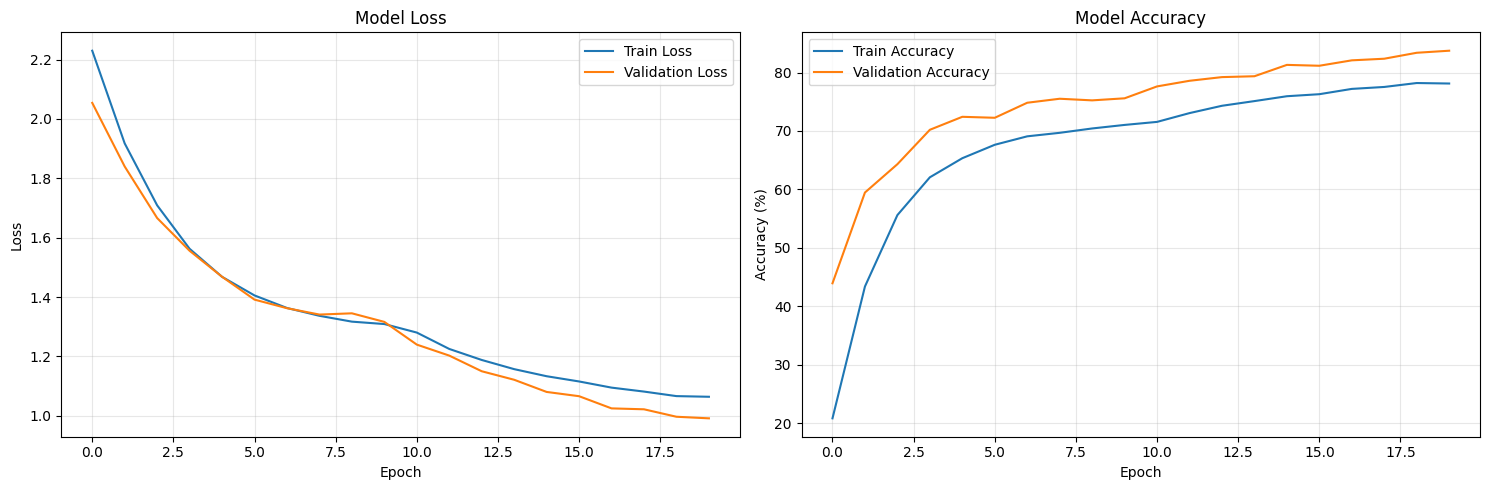

✓ Training history saved to 'training_history_pretrained.png'


In [295]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_pretrained.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history saved to 'training_history_pretrained.png'")

## 14. Generate Test Predictions

In [296]:
# Load best model
print("Loading best model...")
checkpoint = torch.load('best_model_pretrained.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with val acc: {checkpoint['best_val_acc']:.2f}%")

# Generate predictions
print("\nGenerating test predictions...")
model.eval()
test_predictions = []
test_filenames = []

with torch.no_grad():
    for data, filenames in tqdm(test_loader, desc='Inference'):
        data = data.to(CONFIG['device'])
        output = model(data)
        _, predicted = torch.max(output, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_filenames.extend(filenames)

# Convert to class names
test_class_predictions = [IDX_TO_CLASS[pred] for pred in test_predictions]

print(f"\n✓ Generated {len(test_predictions)} predictions")

Loading best model...
Loaded model from epoch 20 with val acc: 83.74%

Generating test predictions...


Inference:   0%|          | 0/133 [00:00<?, ?it/s]


✓ Generated 4232 predictions


## 15. Create Submission File

In [297]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'test_id': [int(os.path.basename(f).replace('test_', '').replace('.npy', '')) 
                for f in test_filenames],
    'label': test_class_predictions
})

# Sort by test_id
submission_df = submission_df.sort_values('test_id').reset_index(drop=True)

# Save
submission_df.to_csv('predictions_pretrained.csv', index=False)

print("✓ Submission file saved: predictions_pretrained.csv")
print(f"\nPrediction distribution:")
print(submission_df['label'].value_counts().sort_index())
print(f"\nFirst 10 predictions:")
print(submission_df.head(10))

✓ Submission file saved: predictions_pretrained.csv

Prediction distribution:
AnnualCrop               303
Forest                   452
HerbaceousVegetation     415
Highway                  704
Industrial               394
Pasture                  190
PermanentCrop            210
Residential              289
River                    203
SeaLake                 1072
Name: label, dtype: int64

First 10 predictions:
   test_id                 label
0        0  HerbaceousVegetation
1        1                 River
2        2  HerbaceousVegetation
3        3               SeaLake
4        4  HerbaceousVegetation
5        5            AnnualCrop
6        6               SeaLake
7        7               SeaLake
8        8  HerbaceousVegetation
9        9               Highway


## 16. Validation Set Evaluation

Evaluating on validation set...


Validation evaluation:   0%|          | 0/169 [00:00<?, ?it/s]


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.8787    0.8450    0.8615       600
              Forest     0.8945    0.9750    0.9330       600
HerbaceousVegetation     0.7723    0.8367    0.8032       600
             Highway     0.6930    0.6500    0.6708       500
          Industrial     0.8210    0.8620    0.8410       500
             Pasture     0.8645    0.7175    0.7842       400
       PermanentCrop     0.7816    0.6440    0.7061       500
         Residential     0.7627    0.8783    0.8164       600
               River     0.9084    0.8920    0.9001       500
             SeaLake     0.9850    0.9833    0.9842       600

            accuracy                         0.8374      5400
           macro avg     0.8361    0.8284    0.8300      5400
        weighted avg     0.8377    0.8374    0.8355      5400



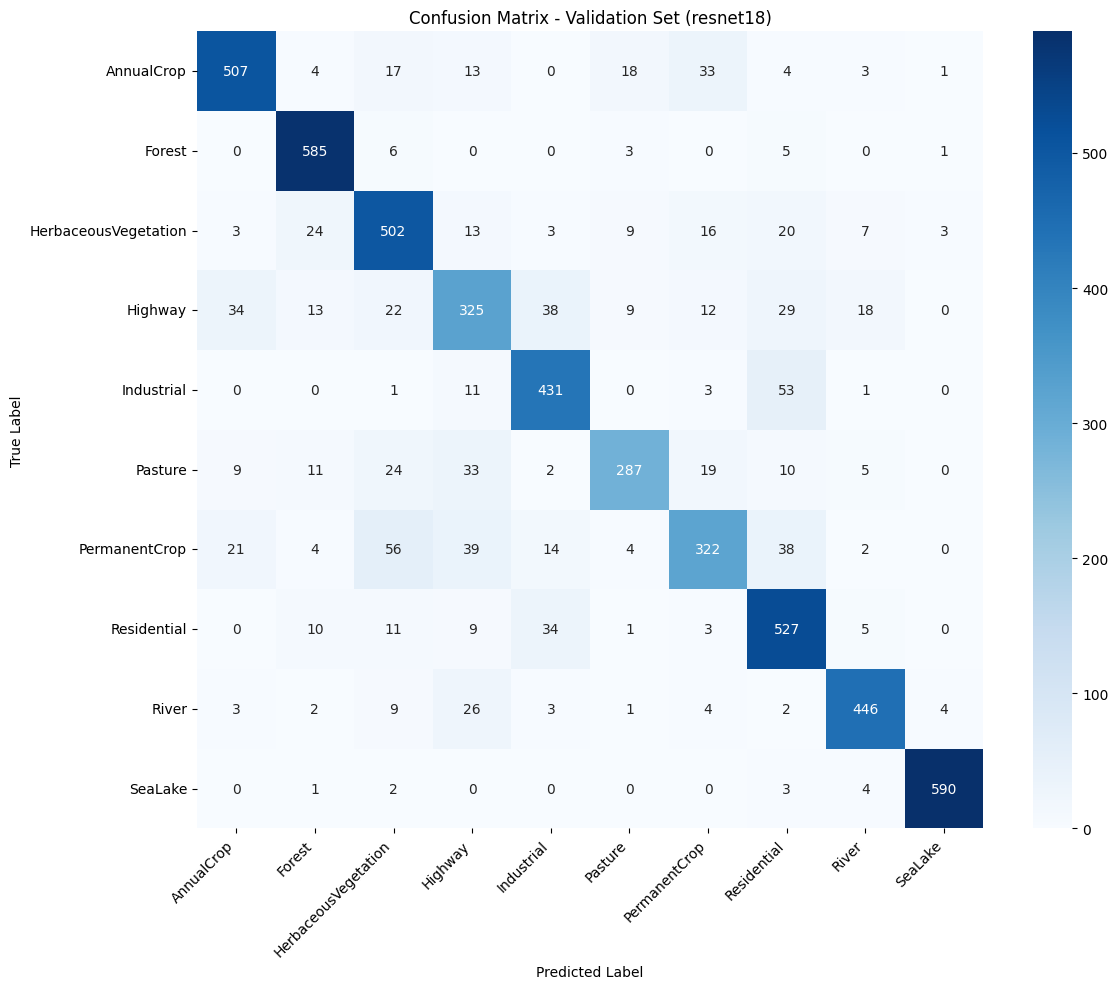

✓ Confusion matrix saved to 'confusion_matrix_pretrained.png'


In [298]:
# Evaluate on validation set
print("Evaluating on validation set...")
model.eval()
val_predictions = []
val_true_labels = []

with torch.no_grad():
    for data, target in tqdm(val_loader, desc='Validation evaluation'):
        data = data.to(CONFIG['device'])
        output = model(data)
        _, predicted = torch.max(output, 1)
        val_predictions.extend(predicted.cpu().numpy())
        val_true_labels.extend(target.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(
    val_true_labels,
    val_predictions,
    target_names=CLASSES,
    digits=4
))

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title(f'Confusion Matrix - Validation Set ({CONFIG["pretrained_model"]})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_pretrained.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to 'confusion_matrix_pretrained.png'")

## Summary

### Implementation Overview

This notebook implements a **pretrained transfer learning approach** for EuroSAT satellite image classification with the following components:

#### Architecture & Model Design
1. **Pretrained ResNet Backbone**: Leverages ImageNet-pretrained weights for faster convergence and better generalization
2. **Custom First Layer**: Adapts the first convolutional layer to accept 11-band satellite input instead of 3-channel RGB
3. **Intelligent Weight Initialization**: RGB weights are replicated across spectral bands and scaled appropriately
4. **Custom Classifier Head**: Replaces the ImageNet classifier with a 2-layer MLP for EuroSAT (10 classes)

#### Data Processing
1. **Correct Band Alignment**: Training data (13 bands in TRAIN_ORDER) is reordered to match test data order (TEST_ORDER), with B9 and B10 removed
2. **Statistical Normalization**: Per-band z-score normalization using training set statistics
3. **Data Augmentation**: Random horizontal/vertical flips and rotations for training robustness

#### Training Strategy
1. **Transfer Learning Options**:
   - **Frozen Backbone** (recommended for limited data): Only trains the classifier head while keeping backbone frozen
   - **Fine-tuning**: Optional full model training with discriminative learning rates (lower for early layers)
2. **Robust Optimization**: AdamW optimizer with weight decay, gradient clipping, and cosine annealing learning rate scheduler
3. **Early Stopping**: Monitors validation accuracy and stops training if no improvement after 10 epochs

#### Domain Adaptation
- Consistent data normalization across training and test sets using training statistics
- Per-band statistical normalization with outlier clipping to handle domain shift

### Expected Output Files

| File | Purpose |
|------|---------|
| `best_model_pretrained.pth` | Best model checkpoint with state dict, optimizer state, history, and training stats |
| `predictions_pretrained.csv` | Test set predictions in submission format (test_id, label) |
| `training_history_pretrained.png` | Training/validation loss and accuracy curves |
| `confusion_matrix_pretrained.png` | Validation set confusion matrix for error analysis |

### Key Configuration Options

- **`freeze_backbone`**: Set to `True` to train only classifier head (faster, lower memory), `False` for full fine-tuning
- **`pretrained_model`**: Choose from 'resnet18' (default), 'resnet34', or 'resnet50'
- **`num_epochs`**: Default 20, with early stopping if validation accuracy plateaus
- **`learning_rate`**: Default 1e-5, automatically adjusted by cosine annealing scheduler
- **`batch_size`**: Default 32, adjust based on available GPU memory

### Reproducibility

Random seeds are set for all libraries (numpy, torch, cuda, mps) to ensure reproducible results across runs. For complete reproducibility, set the PYTHONHASHSEED environment variable:

```bash
PYTHONHASHSEED=0 python -m jupyter notebook
```

### Notes on Band Processing

- **Training data**: 13 bands in order [B1-B9, B10, B11, B12, B8A] → reordered to [B1-B8, B8A, B11, B12] (11 bands)
- **Test data**: 12 bands in order [B1-B8, B8A, B9, B11, B12] → B9 removed → [B1-B8, B8A, B11, B12] (11 bands)
- **Final model input**: 11 channels for all data, ensuring consistent shape throughout pipeline
